In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

### Data Wrangling

In [38]:
# data=pd.read_csv("../S&P_transformed_17-20.csv")
data=pd.read_csv("S&P_500_08-20.csv")
data

,Time,Open,High,Low,Last,Change,Volume
0,5/5/08 9:31,141.040,141.05,140.9900,141.0000,-0.0500,465500.0
1,5/5/08 9:32,140.990,141.02,140.9800,140.9900,-0.0100,294700.0
2,5/5/08 9:33,141.000,141.00,140.8900,140.9200,-0.0700,293200.0
3,5/5/08 9:34,140.920,140.93,140.8500,140.8600,-0.0600,388900.0
4,5/5/08 9:35,140.860,140.96,140.8400,140.9400,0.0800,584500.0
...,...,...,...,...,...,...,...
1402794,11/13/20 15:55,357.920,357.96,357.8100,357.8789,-0.0411,492569.0
1402795,11/13/20 15:56,357.860,357.95,357.8000,357.8200,-0.0589,309294.0
1402796,11/13/20 15:57,357.825,358.21,357.8118,358.2050,0.3850,479111.0
1402797,11/13/20 15:58,358.205,358.35,358.1400,358.3500,0.1450,718921.0


In [39]:
# Narrow data to only datapoints with :59 in them
hour_close=[]
for index, row in data.iterrows():
    if ":59" in str(row["Time"]):
        hour_close.append(row)
data=pd.DataFrame(hour_close)

In [43]:
# # Flipping the dataset
# df = data[::-1].reset_index(drop=True)
# df

In [40]:
data=data[["Open","High","Low","Last","Volume"]]
data

,Open,High,Low,Last,Volume
28,141.2000,141.260,141.140,141.1800,451000.0
88,140.5900,140.600,140.530,140.5400,446700.0
148,140.9000,140.900,140.830,140.8500,190900.0
208,140.8300,140.860,140.800,140.8600,40600.0
268,140.4900,140.530,140.440,140.5200,409400.0
...,...,...,...,...,...
1402558,356.2399,356.355,356.220,356.2700,100894.0
1402618,356.6400,356.740,356.635,356.7399,42318.0
1402678,356.6900,356.700,356.560,356.6000,97078.0
1402738,357.8000,357.810,357.640,357.6600,116020.0


**Scaling the Data**

In [42]:
# Number of datapoints to use in predictions (390 = 1 trading day)
history_points=50
# Value to predict (column index)
column=3

In [43]:
# Scaling data
MinMaxScaler = preprocessing.MinMaxScaler()
X = MinMaxScaler.fit_transform(data)

In [44]:
# Building normalised training data in segments of 50x5
# Get the normalised next day close data
historical_data_normalised =      np.array([X[i  : i + history_points].copy() for i in range(len(X) - history_points)])
next_day_close_values_normalised = np.array([X[:,column][i + history_points].copy() for i in range(len(X) - history_points)])
next_day_close_values_normalised = np.expand_dims(next_day_close_values_normalised, -1)

In [110]:
next_day_close_values_normalised[1]

array([0.25284652])

In [97]:
# Retriving the real next day open values
next_day_close_values = np.array([list(data.iloc[:,column])[i + history_points] for i in range(len(data) - history_points)])
# Expanding the dimentions of next_day_open_values_normalised (5246, 1, 1)
unscaled_y = np.expand_dims(next_day_close_values, -1)

In [101]:
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit(unscaled_y)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [102]:
assert historical_data_normalised.shape[0] == next_day_close_values_normalised.shape[0]

In [103]:
test_split = 0.9 # percent of data to be used for testing
n = int(historical_data_normalised.shape[0] * test_split)

# splitting the dataset up into train and test sets

X_train = historical_data_normalised[:n]
y_train = next_day_close_values_normalised[:n]

X_test = historical_data_normalised[n:]
y_test = next_day_close_values_normalised[n:]

unscaled_y_test = unscaled_y[n:]

In [104]:
# Viewing shape of input data
historical_data_normalised.shape

(21965, 50, 5)

In [105]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
tf.random.set_seed(4)

lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mse')

In [106]:
model.fit(X_train, y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
evaluation = model.evaluate(X_test, y_test)
print(f"Test Loss:{evaluation}")

Epoch 1/50
556/556 [==============================] - 12s 22ms/step - loss: 0.0033 - val_loss: 5.4481e-05
Epoch 2/50
556/556 [==============================] - 12s 21ms/step - loss: 3.0054e-04 - val_loss: 2.9651e-04
Epoch 3/50
556/556 [==============================] - 12s 21ms/step - loss: 2.7959e-04 - val_loss: 1.7173e-04
Epoch 4/50
556/556 [==============================] - 12s 21ms/step - loss: 2.3577e-04 - val_loss: 5.8385e-05
Epoch 5/50
556/556 [==============================] - 12s 21ms/step - loss: 2.2269e-04 - val_loss: 1.1925e-04
Epoch 6/50
556/556 [==============================] - 12s 21ms/step - loss: 2.2249e-04 - val_loss: 5.6909e-05
Epoch 7/50
556/556 [==============================] - 12s 21ms/step - loss: 2.2502e-04 - val_loss: 3.7413e-05
Epoch 8/50
556/556 [==============================] - 12s 21ms/step - loss: 2.1520e-04 - val_loss: 4.0805e-05
Epoch 9/50
556/556 [==============================] - 12s 21ms/step - loss: 2.0388e-04 - val_loss: 1.6020e-04
Epoch 10/50
55

In [107]:
y_test_predicted = model.predict(X_test)
# # # model.predict returns normalised values
# # # now we scale them back up using the y_scaler from before
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

# # # also getting predictions for the entire dataset, just to see how it performs
y_train_predicted = model.predict(X_train)
y_train_predicted = y_normaliser.inverse_transform(y_train_predicted)

# assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(f"Scaled MSE: {scaled_mse}")

Scaled MSE: 7.147483142094492


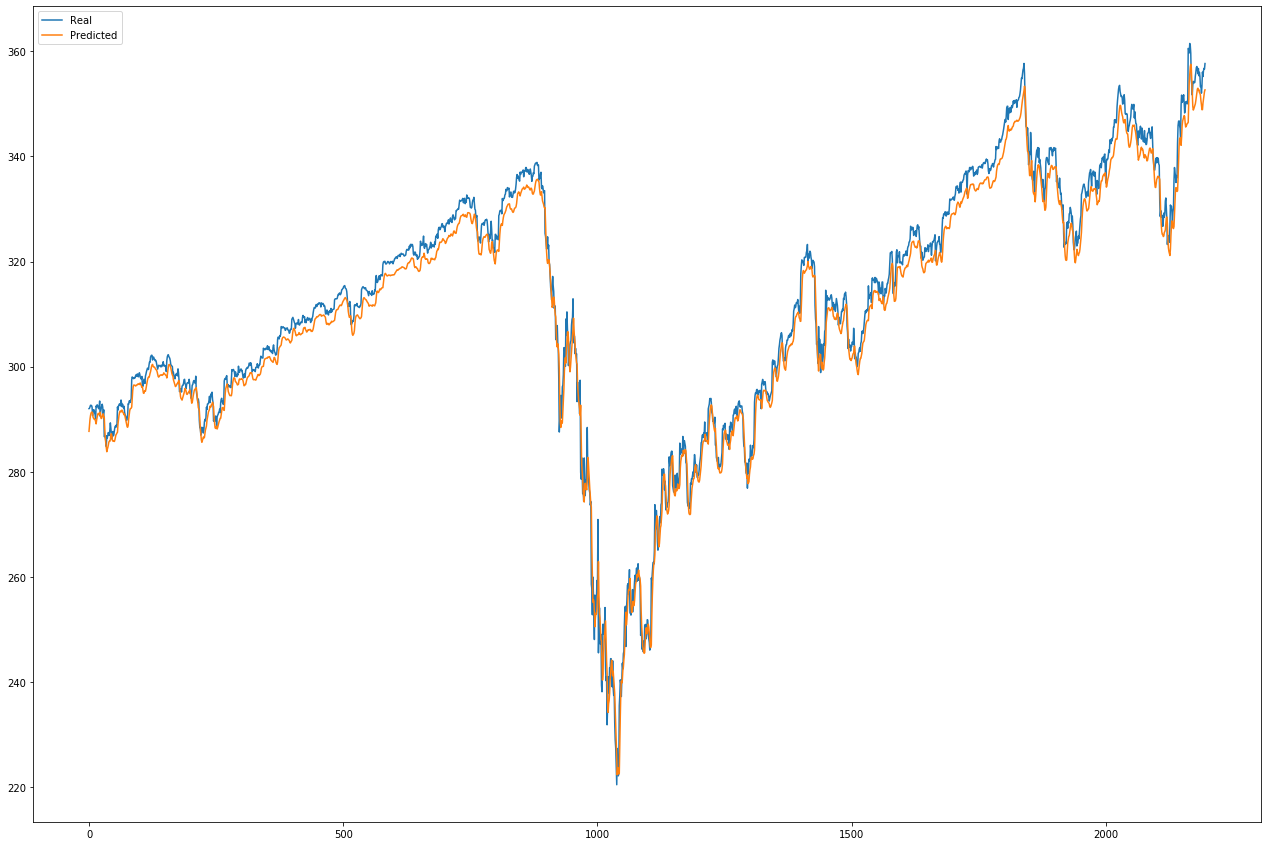

In [108]:
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

In [109]:
model.save("predict_hourly_close.h5")